In [7]:
import pandas as pd
import numpy as np
from anndata import AnnData
import scanpy as sc
import scipy.sparse as sp
from tqdm import tqdm
from paste import pairwise_align
import ot
import torch
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import anndata as ad
import pickle

In [8]:
dataset_path = '/home/hanyuji/Workbench/ST/paste_alignment_cortex/PASTE_align/cortex_macaque1_119slice_subset_12000spot_2000gene_HVG.h5ad'
adata = sc.read_h5ad(dataset_path)

In [9]:
unique_batches = adata.obs['batch'].unique()
adata_list = [adata[adata.obs['batch'] == batch].copy() for batch in unique_batches]

In [10]:
def get_edge_index(M):
    # 将稠密矩阵M转换为稀疏矩阵，并获得边的索引edge_index 
    M_ = coo_matrix(M) # 稠密矩阵--->稀疏矩阵
    values = M_.data
    indices = np.vstack((M_.row, M_.col))  # 我们真正需要的coo形式
    return indices

In [11]:
torch.cuda.set_device(1)  # 将设备设置为 'cuda:0'

import pickle
dir = '/home/hanyuji/Workbench/ST/ST_data_check/paste_alignment_cortex/PASTE_align/'  # 保存的位置


all_pairwise_index = []
# for i in tqdm(range(len(adata_list)-1)):
for i in tqdm(range(1)):

    pi = pairwise_align(sliceA=adata_list[i],sliceB=adata_list[i+1], backend = ot.backend.TorchBackend(), use_gpu = True, numItermax=50000)
    edge_index = get_edge_index(pi)
    all_pairwise_index.append(edge_index)
    

'''保存变量'''
# with open(dir + 'pairwise_index_1000spot_0715.pkl', 'wb') as file:
#     pickle.dump(all_pairwise_index, file)
# print('all_pairwise_index saved')

  0%|          | 0/1 [00:00<?, ?it/s]

gpu is available, using gpu.


/home/hanyuji/miniconda3/envs/PASTE/lib/python3.9/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
100%|██████████| 1/1 [03:33<00:00, 213.73s/it]


'保存变量'

In [13]:
edge_index

array([[    0,     0,     1, ..., 11998, 11998, 11999],
       [ 5611,  5684,  5849, ...,  9282,  9530,  1049]], dtype=int32)

In [9]:
def track_sequence(start, arrays):
    # start是起始数字，arrays是数组列表
    path = [start]  # 轨迹起始
    current = start
    for arr in arrays:
        idx = np.where(arr[0] == current)[0][0]  # 找到current在第一维的位置
        current = arr[1][idx]  # 获取该位置在第二维的对应数字
        path.append(current)  # 添加到路径中
    return path


# 跟踪所有起始数字的轨迹
paths = np.array([track_sequence(i, all_pairwise_index) for i in range(1000)])


'''保存变量'''
# np.save(dir + 'cortex_macaque1_track_sequence_1000spot.npy', paths)
# print('paths saved')


'保存变量'

In [10]:
paths[42]

array([ 42, 573,  86, 226])

# 保存结果

In [6]:
'''加载变量'''

import pickle
dir = '/home/hanyuji/Workbench/ST/ST_data_check/paste_alignment_cortex/PASTE_align/'  # 保存的位置

# with open(dir + 'pairwise_index_5000spot_0713.pkl', 'rb') as file:
#     all_pairwise_index = pickle.load(file)

paths = np.load(dir + 'cortex_macaque1_track_sequence_1000spot.npy')



In [12]:
paths

array([[  0, 697, 133, 315],
       [  1,  31, 223, 768],
       [  2, 419, 368, 971],
       ...,
       [997, 755, 968, 352],
       [998, 950, 955, 121],
       [999, 524, 364, 107]])

# 可视化

In [3]:
with open('alignment_failure_para.pkl', 'rb') as f:
    loaded_variables = pickle.load(f)

# 更新当前的全局变量
globals().update(loaded_variables)

In [14]:
slice_0 = adata_list[0]
slice_1 = adata_list[1]


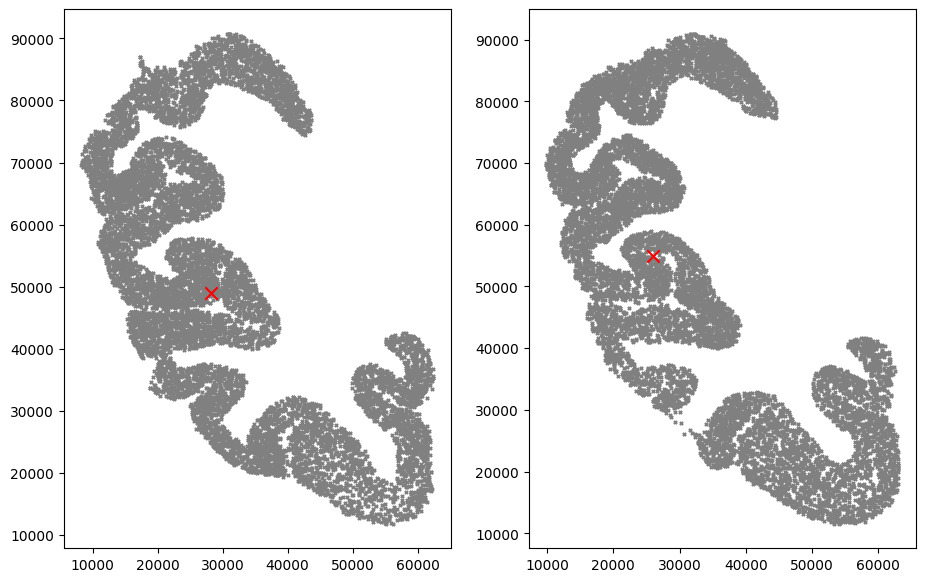

In [15]:
def plt_aligned_point(choiced_index):
    '''
    随机选取两个对齐的spot
    展示两个点的坐标
    持续1s
    '''
    coo_all_0 = slice_0.obsm['spatial']
    coo_all_1 = slice_1.obsm['spatial']

    aligned_point_0 = coo_all_0[edge_index[0,choiced_index]]
    aligned_point_1 = coo_all_1[edge_index[1,choiced_index]]

    fig, axs = plt.subplots(1, 2, figsize=(11, 7))
    # 背景
    axs[0].scatter(coo_all_0[:, 0], coo_all_0[:, 1], c='gray', marker='x',s=5)
    axs[1].scatter(coo_all_1[:, 0], coo_all_1[:, 1], c='gray', marker='x',s=5)
    # 对齐的两个点
    axs[0].scatter(aligned_point_0[0], aligned_point_0[1], c='r', marker='x',s=80)
    axs[1].scatter(aligned_point_1[0], aligned_point_1[1], c='r', marker='x',s=80)    

    plt.show()
    # display(plt.gcf())
    time.sleep(1)  # 等待1秒钟
    clear_output(wait=True)


import time
from IPython.display import clear_output, display

for i in range(10):
    choiced_index = np.random.randint(1000)
    plt_aligned_point(choiced_index)

In [35]:
def is_pickleable(obj):
    try:
        pickle.dumps(obj)
    except (pickle.PicklingError, TypeError):
        return False
    return True

variables = globals()  # 获取所有变量
# 指定要保存的变量名称（排除一些不需要保存的系统变量和不可序列化的对象）
variables_to_save = {k: v for k, v in variables.items() if not k.startswith('__') and not callable(v) and is_pickleable(v)}
with open('alignment_failure_para.pkl', 'wb') as f:
    pickle.dump(variables_to_save, f)

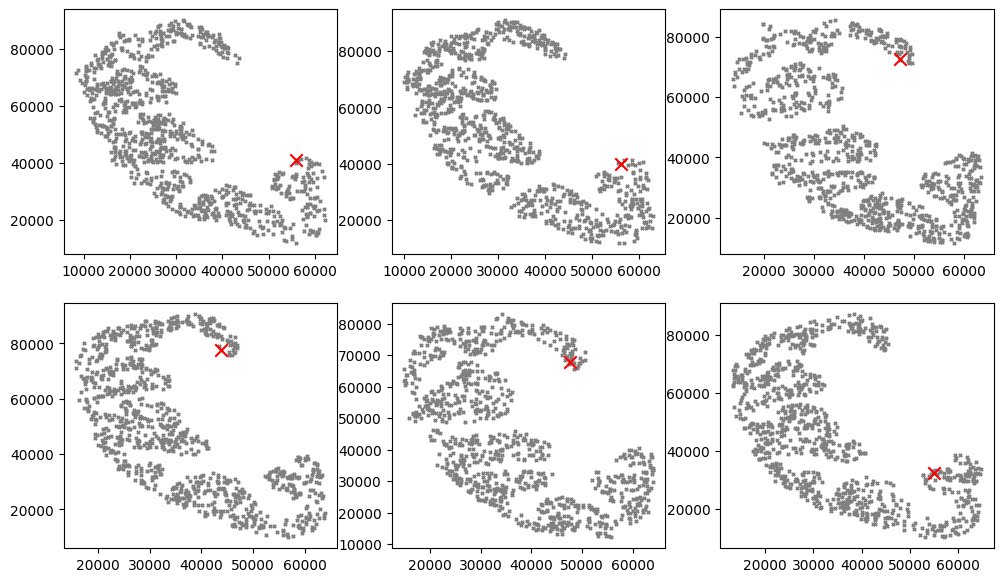

In [27]:
def plt_aligned_point(choiced_index):
    '''
    随机选取两个对齐的spot
    展示两个点的坐标
    持续1s
    '''

    aligned_point = [coo_all[i][paths[choiced_index,i]] for i in range(0,6)]

    fig, axs = plt.subplots(2, 3, figsize=(12, 7))
    
    # 背景
    for i in range(6):
        if i<3:
            axs[0, i].scatter(coo_all[i][:, 0], coo_all[i][:, 1], c='gray', marker='x',s=5)
        else:
            axs[1, i-3].scatter(coo_all[i][:, 0], coo_all[i][:, 1], c='gray', marker='x',s=5)

    # 对齐的两个点
    for i in range(6):
        if i<3:
            axs[0, i].scatter(aligned_point[i][0], aligned_point[i][1], c='r', marker='x',s=80)
        else:
            axs[1, i-3].scatter(aligned_point[i][0], aligned_point[i][1], c='r', marker='x',s=80)

    plt.show()
    # display(plt.gcf())
    time.sleep(1)  # 等待1秒钟
    clear_output(wait=True)


import time
from IPython.display import clear_output, display

for i in range(15):
    choiced_index = np.random.randint(1000)
    plt_aligned_point(choiced_index)


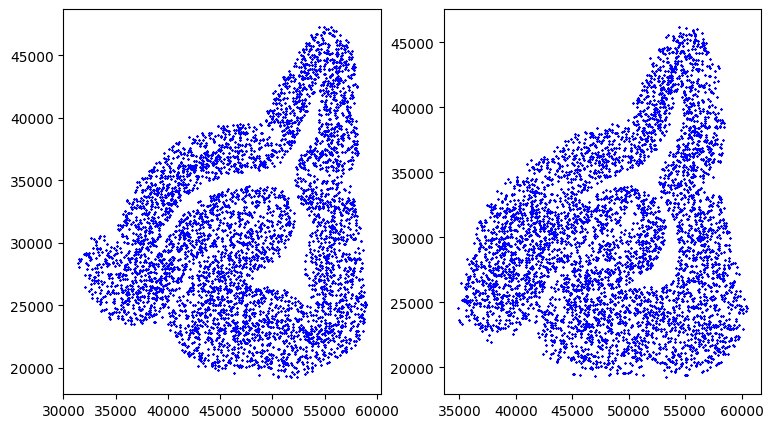

In [22]:
import matplotlib.pyplot as plt

s0_1 = [slice_0,slice_1]
fig, axs = plt.subplots(1, 2, figsize=(9, 5))

for i, ax in enumerate(axs.flat):
    coo = pd.DataFrame(s0_1[i].obsm['spatial'])
    ax.scatter(coo[0], coo[1], c='b', marker='x',s=1)

plt.show()